# Convolution Layer

In [1]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import math

In [2]:
# !rm -rf ./imitools && git clone https://github.com/GDi4K/imitools.git
!pip -q install duckduckgo_search
import imitools as I

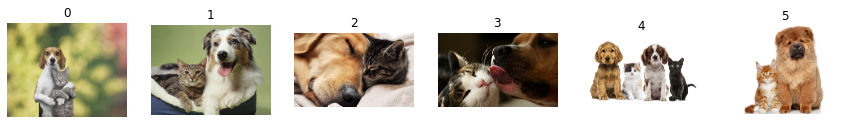

In [3]:
I.search_images("Cats & Dogs").show()

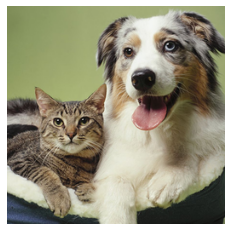

In [18]:
I.search_history().pick(1).crop(256).show()

In [19]:
image = I.search_history().pick(1).crop(256).pt()
image.shape

torch.Size([1, 3, 256, 256])

## Core Functions

In [20]:
def apply_pad(tensor, n_pad=1):
    tw, th = tensor.shape
    y = torch.zeros(tw + n_pad * 2, th + n_pad *2).to(tensor.device)
    y[n_pad:n_pad + tw, n_pad:n_pad + th] = tensor
    return y

In [21]:
def run_conv(X, K, n_pad=0, n_stride=1):
    assert len(X.shape) == 2, "Only 2D tensors are supported"
    X = apply_pad(X, n_pad)
    kw, kh = K.shape
    xw, xh = X.shape
    yw = math.floor((xw - kw) / n_stride  + 1)
    yh = math.floor((xh - kh) / n_stride  + 1)
    
    Y = torch.zeros(yw, yh).to(X.device)
    for u in range(yw):
        for v in range(yh):
            xu, xv = u*n_stride, v*n_stride
            selection = X[xu:xu+kw, xv:xv+kh]
            Y[u, v] = (selection*K).sum()
    return Y

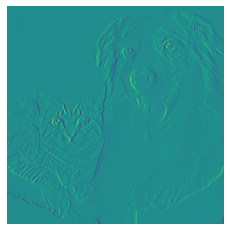

In [22]:
im = run_conv(image[0][0], torch.FloatTensor([[1, -1]]))
I.wrap(im).show()

## Making the Convolution Layer

We have to match input & ouput convolutions.

In [23]:
device = "cuda"

In [24]:
# output layers = 5
# input layers 3
# kernal size = 4
test_image = image[0].to(device)
kernals = torch.randn(5, 3, 4, 4).to(device)
biases = torch.randn(5).to(device)

In [25]:
def run_conv_layer(image, kernals, biases, n_pad=0, n_stride=1):
    assert len(image.shape) == 3, "Only single images are allowed for now"
    n_out_layers, n_in_layers, kernal_size, _ = kernals.shape
    
    out_layers = []
    for oi in range(n_out_layers):
        frames = []
        for ii in range(n_in_layers):
            kernal = kernals[oi, ii]
            frames.append(run_conv(image[ii], kernal, n_pad, n_stride) + biases[oi])
            
        out_layers.append(torch.stack(frames).sum(dim=0))
        
    return torch.stack(out_layers)

In [26]:
%time result = run_conv_layer(test_image, kernals, biases, n_pad=1, n_stride=2)
result.shape

CPU times: user 24.3 s, sys: 474 ms, total: 24.8 s
Wall time: 7.14 s


torch.Size([5, 128, 128])

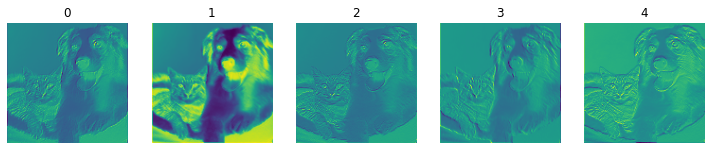

In [27]:
I.wrap(result.unsqueeze(1)).show()

See. Our convolution layer works. We input an RGB image (with 3 layers) & we can get 5 layers back.
So, the idea is that via backpropergation, we can train these kernals to something useful.

## Making It Faster

Our current setup works, but it's super slow. Let's use what's inside PyTorch to make these run faster.

In [28]:
conv_layer = torch.nn.Conv2d(in_channels=3, out_channels=5, kernel_size=4, padding=1, stride=2).to(device)

In [29]:
%time result2 = conv_layer(test_image)
result2.shape

CPU times: user 1.21 ms, sys: 74 µs, total: 1.28 ms
Wall time: 657 µs


torch.Size([5, 128, 128])

**See. How fast it is.**

We don't need to optimize our function for now since we are only interested on how these things works.

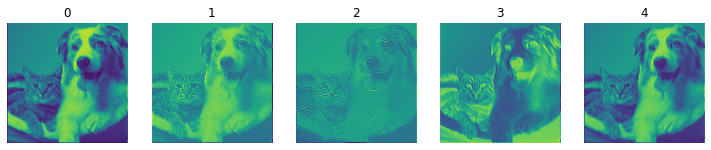

In [30]:
I.wrap(result2.unsqueeze(1)).show()

In [31]:
kernals2, biases2 = list(conv_layer.parameters())
kernals2.shape, biases2.shape

(torch.Size([5, 3, 4, 4]), torch.Size([5]))

**See. They have the same kernals & biases as our setup**

So, we can use this when we are building the rest of the layers.